# Connecting MYSQL to PYTHON

In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1992024',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/sanju/OneDrive/Documents/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Importing Libraries And Connecting

In [1]:
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as sea
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1992024',
    database='ecommerce')
cur = db.cursor()



# QAUTIONS FOR PROJECT

# List all unique cities where customers are located. 

In [2]:
import mysql.connector

query =  """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [3]:

query =  """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

'tatal order placed in 2017 are' ,data[0][0]

('tatal order placed in 2017 are', 90202)

# Find the total sales per category.

In [4]:

query =  """select upper(products.product_category) category,round(sum(payments.payment_value),2)sales
from products join order_items
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# Calculate the percentage of orders that were paid in installments.

In [5]:
query =  """select sum(case when payment_installments >=1 then 1 else 0 end) /count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()

"persentage of orders paid in installment is ",data[0][0]

('persentage of orders paid in installment is ', Decimal('99.9981'))

# Count the number of customers from each state.

   state  total
0     SP  83492
4     RJ  25704
2     MG  23270
5     RS  10932
3     PR  10090
1     SC   7274
9     BA   6760
13    DF   4280
8     ES   4066
7     GO   4040
15    PE   3304
12    CE   2672
6     PA   1950
16    MT   1814
10    MA   1494
11    MS   1430
21    PB   1072
23    PI    990
14    RN    970
19    AL    826
25    SE    700
22    TO    560
20    RO    506
17    AM    296
24    AC    162
18    AP    136
26    RR     92


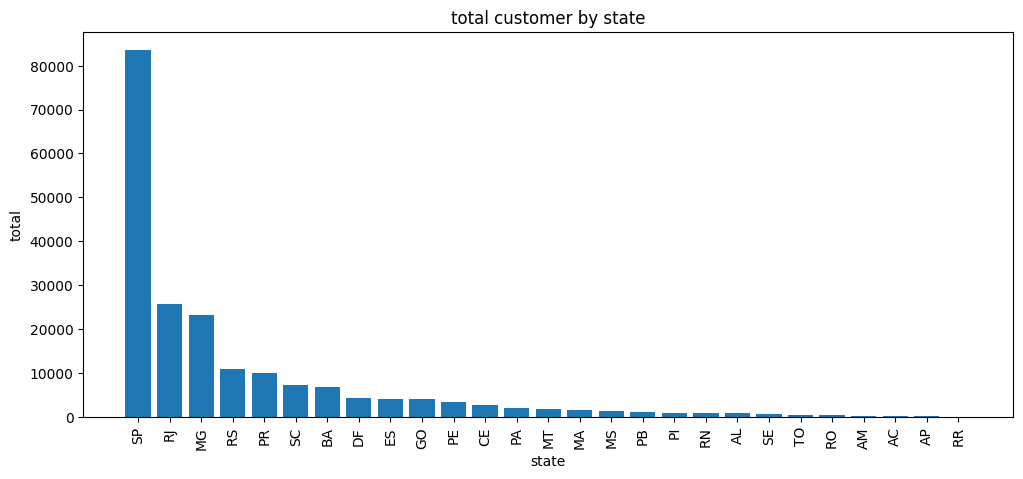

In [37]:
query =  """select customer_state, count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["state","total"])
df = df.sort_values(by = "total", ascending = False )
print(df)

mp.figure(figsize = (12,5))
mp.bar(df["state"],df["total"])
mp.xticks(rotation = 90)
mp.xlabel("state")
mp.ylabel("total")
mp.title("total customer by state")
mp.show()

# Calculate the number of orders per month in 2018.

      months  orders
5    January   14538
4      March   14422
7      April   13878
6        May   13746
2   February   13456
1     August   13024
0       July   12584
3       June   12334
8  September      32
9    October       8


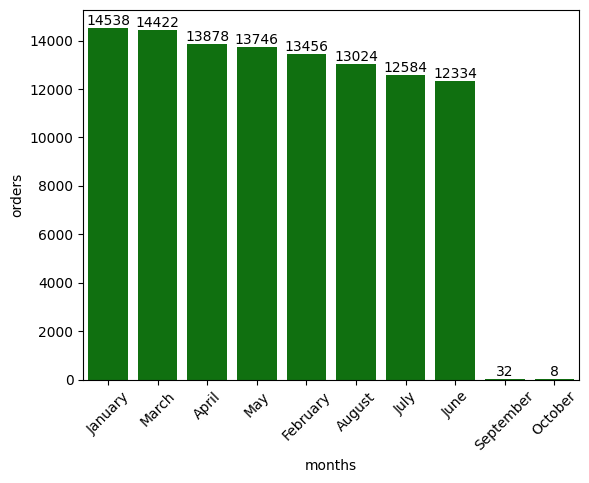

<Figure size 1000x1500 with 0 Axes>

In [7]:
query =  """select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders
where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","orders"])
df = df.sort_values(by = "orders", ascending = False)
print(df)



fx = sea.barplot(data = df,x=df["months"],y=df["orders"], color = "green")
mp.xticks(rotation = 45)
mp.figure(figsize =(10,15))
fx.bar_label(fx.containers[0])


mp.show()

# Find the average number of products per order, grouped by customer city.

In [8]:
query =  """with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc from orders
join order_items on orders.order_id = order_items.order_id group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders from customers join count_per_order
on customers.customer_id = count_per_order.customer_id group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city","average product/order"])
df.head(10)

,customer city,average product/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [9]:
query =  """select upper(products.product_category) category,round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) sales
from products join order_items
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","persentage distribution"])
df

,category,persentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


# Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
query =  """select products.product_category,count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items on
products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","order count","price"])

print(df)

arr1 = df["order count"]
arr2 = df["price"]

 
a = np.corrcoef([arr1,arr2])
print(" the correlation between time and number of times a products as been purchased is", a[0][-1])

                           category  order count   price
0                     HEALTH BEAUTY        19340  130.16
1                     sport leisure        17282  114.34
2                        Cool Stuff         7592  167.36
3              computer accessories        15654  116.51
4                   Watches present        11982  201.14
..                              ...          ...     ...
69                          flowers           66   33.64
70  Kitchen portable and food coach           30  264.57
71       CITTE AND UPHACK FURNITURE           76  114.95
72                  House Comfort 2           60   25.34
73                   cds music dvds           28   52.14

[74 rows x 3 columns]
 the correlation between time and number of times a products as been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

([0, 1, 2, 3, 4],
 [Text(0, 0, '7c67e1448b00f6e969d365cea6b010ab'),
  Text(1, 0, '1025f0e2d44d7041d6cf58b6550e0bfa'),
  Text(2, 0, '4a3ca9315b744ce9f8e9374361493884'),
  Text(3, 0, '1f50f920176fa81dab994f9023523100'),
  Text(4, 0, '53243585a1d6dc2643021fd1853d8905')])

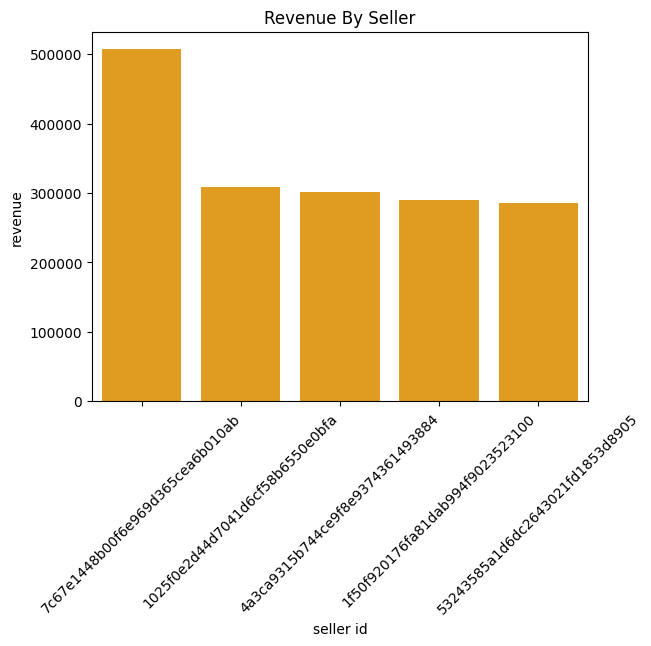

In [32]:
query =  """select *,dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller id","revenue","rank"])
df = df.head()
sea.barplot(x = "seller id", y = "revenue",data = df,color = "orange" )
mp.xlabel("seller id")
mp.ylabel("revenue")
mp.title("Revenue By Seller")
mp.xticks(rotation = 45)

# Calculate the moving average of order values for each customer over their order history.

In [40]:
query =  """select customer_id, order_purchase_timestamp,payment,avg(payment) over(partition by customer_id
order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment from 
payments join orders on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer id","order_purchase_timestamp","payment","mov_avg"])
df

,customer id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

    years  months     payment  cumulitive_sales
0    2016       9      504.48            504.48
1    2016      10   118180.96         118685.44
2    2016      12       39.24         118724.68
3    2017       1   276976.08         395700.76
4    2017       2   583816.02         979516.78
5    2017       3   899727.20        1879243.98
6    2017       4   835576.06        2714820.04
7    2017       5  1185837.64        3900657.68
8    2017       6  1022552.76        4923210.44
9    2017       7  1184765.84        6107976.28
10   2017       8  1348792.64        7456768.92
11   2017       9  1455524.90        8912293.82
12   2017      10  1559355.76       10471649.58
13   2017      11  2389765.60       12861415.18
14   2017      12  1756802.96       14618218.14
15   2018       1  2230008.36       16848226.50
16   2018       2  1984926.68       18833153.18
17   2018       3  2319304.24       21152457.42
18   2018       4  2321570.96       23474028.38
19   2018       5  2307964.30       2578

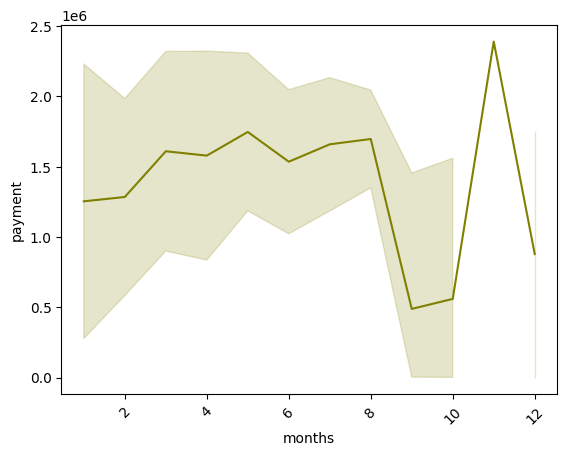

In [74]:
query =  """select years, months , payment, sum(payment) over(order by years, months)cumulitive_sales from
(select year(orders.order_purchase_timestamp) as years,month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment","cumulitive_sales"])
print(df)

sea.lineplot(data = df, x = "months", y = "payment",color = "olive")
mp.xticks(rotation = 45)
mp.show()

#  Calculate the year-over-year growth rate of total sales.

In [57]:
query ="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments on orders.order_id = payments.order_id
group by years order by years)


select years,((payment - lag(payment, 1) over(order by years)) / lag(payment, 1) over(order by years))*100 previos_year from a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","yoy % growth"])
print(df)

   years  yoy % growth
0   2016           NaN
1   2017  12112.703761
2   2018     20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [58]:

query ="""WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id,
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders ON orders.customer_id = a.customer_id
    WHERE orders.order_purchase_timestamp > first_order
      AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id))
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


# Identify the top 3 customers who spent the most money in each year.

   years                                id       payment  rank
3   2017  1617b1357756262bfa56ab541c47bc16  27328.160156     1
6   2018  ec5b2ba62e574342386871631fafd3fc  14549.759766     1
4   2017  c6e2731c5b391845f6800c97401a43a9  13858.620117     2
7   2018  f48d464a0baaea338cb25f816991ab1f  13844.419922     2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6  13453.320312     3
8   2018  e0a2412720e9ea4f26c1ac985f6a7358   9618.879883     3
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   2847.100098     1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   2801.479980     2
2   2016  4a06381959b6670756de02e07b83815f   2455.560059     3


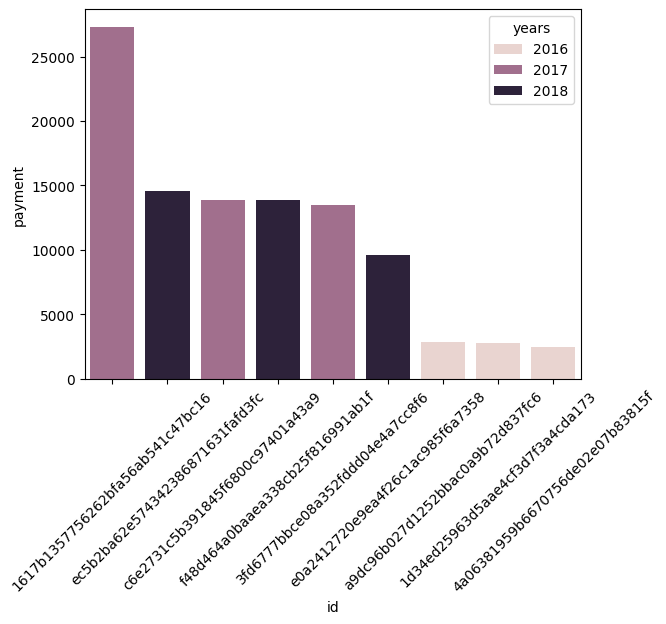

In [71]:
query ="""WITH ranked_customers AS (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
           orders.customer_id,
           SUM(payments.payment_value) AS payment,
           DENSE_RANK() OVER (
               PARTITION BY YEAR(orders.order_purchase_timestamp)
               ORDER BY SUM(payments.payment_value) DESC
           ) AS d_rank
    FROM orders
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
)
SELECT years, customer_id, payment, d_rank
FROM ranked_customers
WHERE d_rank <= 3
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
df = df.sort_values(by = "payment", ascending = False)
print(df)

sea.barplot(data = df,x = "id",y = "payment",hue = "years")
mp.xticks(rotation = 45)
mp.show()